# Analyze dwell times (notebook 3)

This notebook produces a split violin plot of raw dwell-time data, one violin per reference genome nucleotide position.
Each violin will show IVT dwell-time distributions on the left, and Trizol IVT distributions on the right.

**Input:** two CSV files containing per-read per-position dwell times extracted from fast5 files

**Output:** violin plots

In [200]:
from os import environ, path
import shutil
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns

To make things faster, let's try copying our input data onto our compute node's local filesystem.

In [2]:
def copy_to_node(src_path):
    '''
    Copy a file to local storage on the current compute node. (I don't know
    if this would work for Jupyter Notebook sessions running on multiple
    nodes.)
    
    Args:
        src_path (str): filepath to the file to be copied
    
    Returns:
        str: Absolute path to the new file location
    '''
    src_basename = path.basename(src_path)
    node_path = environ['TMPDIR'] # environment variable (local node directory)
    dest_path = path.join(node_path, src_basename)
    shutil.copyfile(src_path, dest_path)
    return dest_path

In [3]:
ivt_path = "/fs/project/PAS1405/extract_dwells_3/f1f2_GL_dwells.csv"
trizol_path = "/fs/project/PAS1405/extract_dwells_3/Trizol_OLD_8K_single_fast5_dwells.csv"

ivt_path = copy_to_node(ivt_path)
trizol_path = copy_to_node(trizol_path)

print(ivt_path)
print(trizol_path)

/tmp/pbstmp.10935695/f1f2_GL_dwells.csv
/tmp/pbstmp.10935695/Trizol_OLD_8K_single_fast5_dwells.csv


In [4]:
def load_dwell_csv(csv_path):
    '''
    Load a CSV of per-read per-position dwell times into a dataframe.
    
    Args:
        csv_path (str): path to the CSV file
    
    Returns:
        pd.DataFrame: a dataframe containing FLOAT dwell times
            * rows labeled by read_id (str)
            * columns labeled by genomic position number (int)
    '''
    retval = (
        pd.read_csv(csv_path, header=0, index_col=0)
        .rename_axis('read_id', axis=0)
        .rename_axis('pos', axis=1)
    )
    retval.columns = retval.columns.astype(int)
    return retval

In [5]:
# This cell takes about 5 minutes on one full Owens cluster node.

trizol_dwells = load_dwell_csv(trizol_path)
print('trizol_dwells loaded')
ivt_dwells = load_dwell_csv(ivt_path)
print('ivt_dwells loaded')
print('done')

trizol_dwells loaded
ivt_dwells loaded
done


In [6]:
pos_intersection = ivt_dwells.columns.intersection(trizol_dwells.columns)
pos_intersection

Int64Index([   7,    8,    9,   10,   11,   12,   13,   14,   15,   16,
            ...
            9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170],
           dtype='int64', name=u'pos', length=9164)

In [281]:
def plotter_1(lo, hi, series_a, series_b, fig, ax, vlines=[]):
    '''
    Args:
        lo (int): the lowest-numbered nucleotide to plot (inclusive)
        hi (int): the upper limit of the nucleotide range to plot (inclusive)
        series_a:  
        series_b: 
        fig: a figure to alter
        ax: an axis to alter
        
    Returns:
        None
    '''

    pos_labels = pos_intersection[
        (lo <= pos_intersection) & (pos_intersection <= hi)
    ]

    points = 30 # 2000
    trizol_parts = ax.violinplot(
        series_a.iloc[:, pos_labels].dropna().values,
        showextrema=False,
        points=points,
    )
    ivt_parts = trizol_parts = ax.violinplot(
        series_b.iloc[:, pos_labels].dropna().values,
        showextrema=False,
        points=points,
    )

    for body in trizol_parts['bodies']:
        body.set_edgecolor('black')
    for body in ivt_parts['bodies']:
        body.set_edgecolor('black')

    ymin, ymax = 0, 150
    ax.set_ylim(ymin, ymax)
    
    vline_args = {'linewidth':'4', 'alpha':0.4}
    ax.axvline(map(lambda x: list(pos_labels).index(x) + 1, vlines), 0, 1, color='r', **vline_args) # plot red lines at each point of vlines
    ax.axvline(map(lambda x: list(pos_labels).index(x) + 11, vlines), 0, 1, color='g', **vline_args) # plot green lines at +10 bp
    
    ax.set_xticks(np.arange(len(pos_labels)+1))
    ax.set_xticklabels(pos_labels.insert(0, ''))
    
    ax_label_params = {'fontsize':18}
    ax.set_ylabel('Dwell time (number of measurements)', **ax_label_params)
    ax.set_xlabel('Nucleotide position (zero-based)', **ax_label_params)

8078
8710
8974


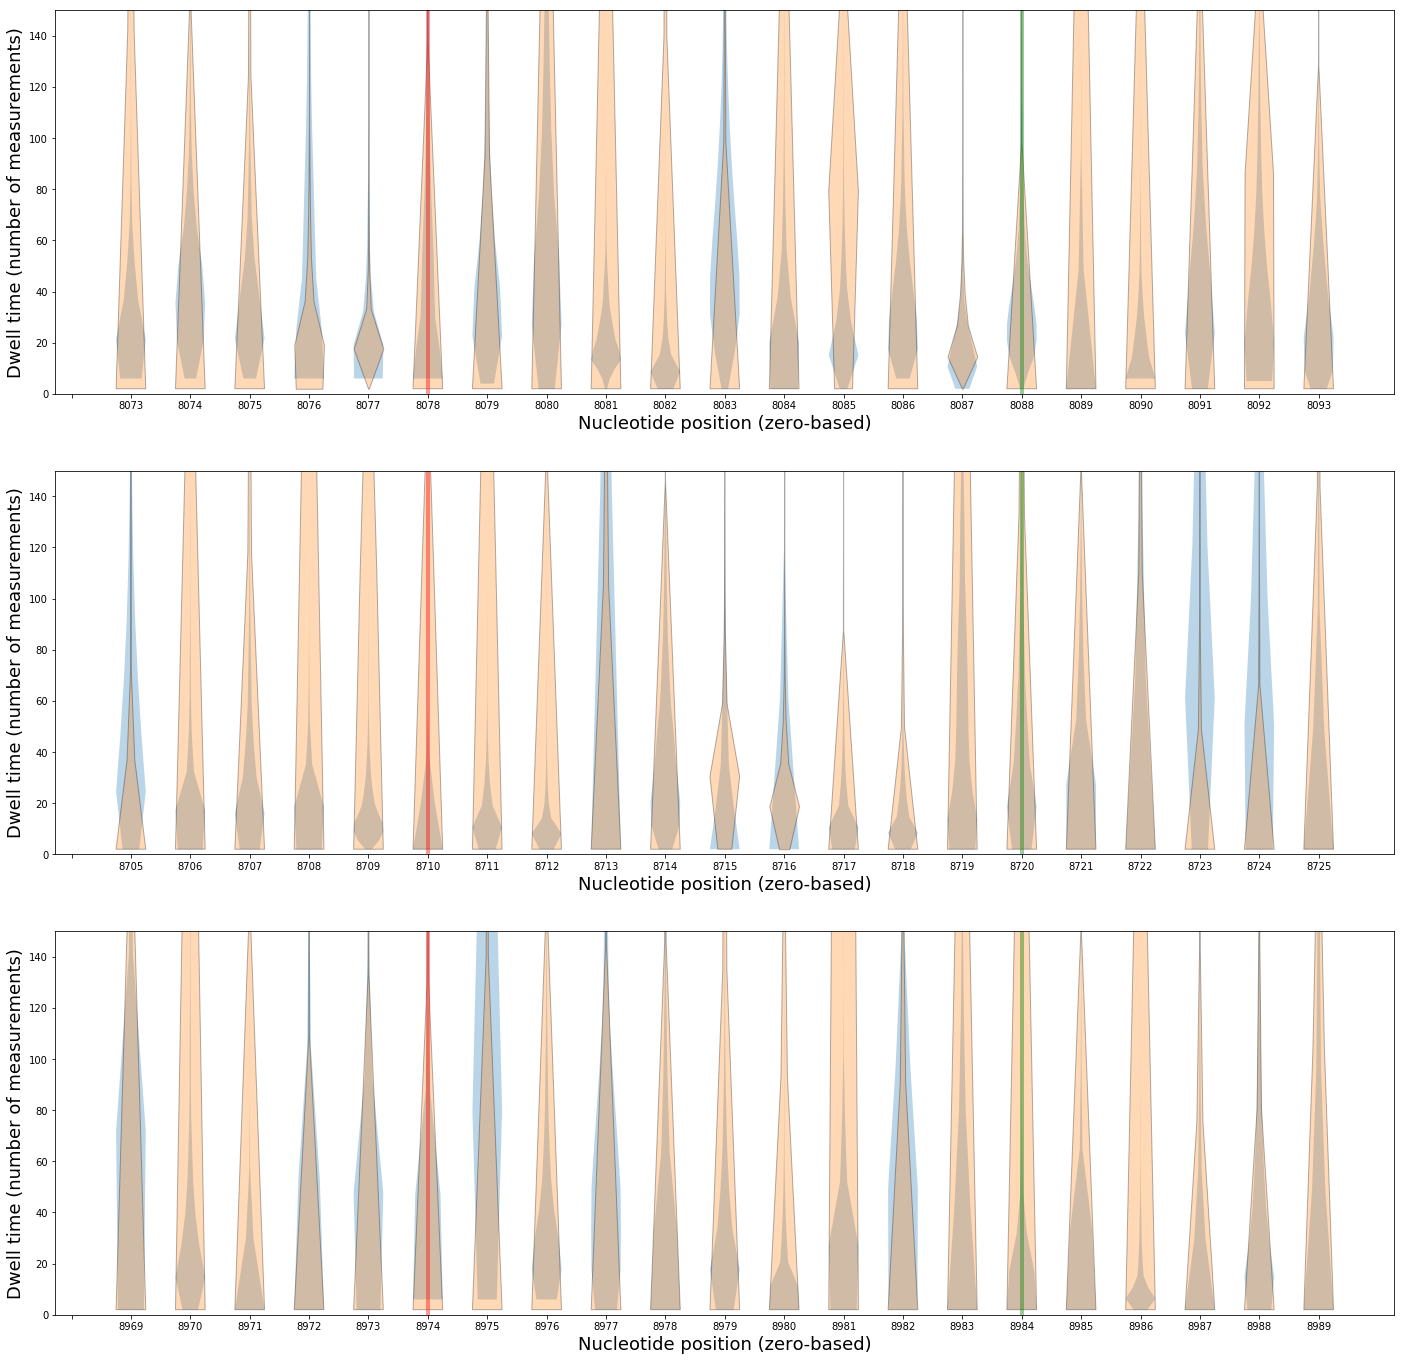

In [282]:
centers = (8078, 8710, 8974)
fig, axes = plt.subplots(len(centers), 1, figsize=(24,8*len(centers)))
for center, ax in zip(centers, axes):
    print(center)
    plotter_1(center-5, center+15, series_a=trizol_dwells, series_b=ivt_dwells, fig=fig, ax=ax, vlines=[center])
fig.savefig('violin_plots_three_positions.png')
fig.legend(
fig.show()

In [280]:
fig.savefig('violin_plots_three_positions.png')